# Projeto Final - Processamento de Big Data
# This Week in Chess Archive
## Trabalho Realizado por:
### Adília Lourenço 123403
### Maria Inês Teixeira 123420
### Matilde Carvalho 123401
### Joana Nunes 123429


In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.getOrCreate()

In [81]:
spark

### Ingestão dos dados(ETL) 

Começou-se por carregar o ficheiro "twic_master.parquet" que contém a base de dados de partidas de xadrez (este ficheiro é igual ao csv mas o formato parquet é mais adequado para Spark e mais leve) e o ficheiro metadata.csv – formou-se, assim, dois dataframes: df_twic e df_meta;

In [4]:
# Leitura do Parquet e CSV
df_twic = spark.read.parquet("twic_master.parquet")
df_meta = spark.read.option("header", True).csv("metadata.csv", inferSchema=True)

In [5]:
df_twic.count()

1971319

#### Após se verificar o tamanho do df_twic: 1971319, fez-se uma sub amostra mais leve com apenas 5% dos dados para ser possível trabalhar com a base de dados de uma forma mais prática (caso seja necessário utilizar esta sub amostra é só colocar fraction=0.05) – df_twic_sample tamanho: 98797 – e guardou-se esse ficheiro parquet. Após a resolução do trabalho, este código foi executado com 10% da base de dados (equivalente a fraction=0.1) e os valores referidos posteriormente, correspondem a essa percentagem da base de dados.

In [42]:
# Amostra de 5% dos dados, sem substituição
df_twic_sample = df_twic.sample(withReplacement=False, fraction=0.05, seed=42)
# Verificar número de linhas
print("Total original:", df_twic.count())
print("Amostra criada:", df_twic_sample.count())

Total original: 1971319
Amostra criada: 98797


In [43]:
df_twic_sample.write.mode("overwrite").parquet("amostra/twic_sample.parquet")

In [44]:

df_sample = spark.read.parquet("amostra/twic_sample.parquet")

### Exploração e Limpeza dos dados

In [9]:
df_sample.show()

+-----------+----------------+------------------+-------------------+----------+----------------+-------+--------------------+-----------------+------+-----+---+--------------------+-----------+-----------+--------+--------+--------------------+----------+----------+---------+---------+---------+----+-----+-------+-----+--------+-------------+
|twic_number|           White|             Black|               Date| EventDate|           Event| Result|      mainline_moves|             Site|Online|Round|ECO|             Opening|WhiteFideId|BlackFideId|WhiteElo|BlackElo|           Variation|WhiteTitle|BlackTitle|WhiteTeam|BlackTeam|EventType| FEN|SetUp|Variant|Board|PlyCount|EventCategory|
+-----------+----------------+------------------+-------------------+----------+----------------+-------+--------------------+-----------------+------+-----+---+--------------------+-----------+-----------+--------+--------+--------------------+----------+----------+---------+---------+---------+----+-----+

Nesta etapa de exploração dos dados (do sample), verificou-se que as colunas "EventType", "FEN", "SetUp", "Variant", "Board", "PlyCount", "EventCategory", "WhiteTeam", "BlackTeam" estão praticamente nulas, uma vez que não existem ou não são usadas de forma consistente nos pgns originais.
Assim, após uma interpretação sobre a relevância destas colunas no contexto do problema, decidiu-se que apenas "PlyCount" é importante manter.

In [45]:
# verificar se as últimas 9 colunas estão completamente nulas
from pyspark.sql.functions import col, count, when
# Selecionar apenas as últimas 9 colunas
ultimas_colunas = [
    "EventType", "FEN", "SetUp", "Variant",
    "Board", "PlyCount", "EventCategory",
    "WhiteTeam", "BlackTeam"  
]
# Contar nulos em cada coluna
df_sample.select([
    count(when(col(c).isNull(), c)).alias(f"{c}_nulls") for c in ultimas_colunas
]).show()


+---------------+---------+-----------+-------------+-----------+--------------+-------------------+---------------+---------------+
|EventType_nulls|FEN_nulls|SetUp_nulls|Variant_nulls|Board_nulls|PlyCount_nulls|EventCategory_nulls|WhiteTeam_nulls|BlackTeam_nulls|
+---------------+---------+-----------+-------------+-----------+--------------+-------------------+---------------+---------------+
|          88998|    98769|      98769|        98769|      98793|         98797|              98797|          79373|          79374|
+---------------+---------+-----------+-------------+-----------+--------------+-------------------+---------------+---------------+



A partir da coluna “mainline_moves” obteu-se uma estimativa de “PlyCount”: contou-se o número de elementos separados por espaço (um para cada jogada), aproximando-se, assim, do valor real de plies – substituiu-se os nulos de “PlyCount” por esse cálculo

In [46]:
from pyspark.sql.functions import when, col, split, size

df_sample = df_sample.withColumn(
    "PlyCount",
    when(col("PlyCount").isNull(), size(split(col("mainline_moves"), " ")))
    .otherwise(col("PlyCount"))
)


In [47]:
df_sample.select("PlyCount").show(20)

+--------+
|PlyCount|
+--------+
|     126|
|     147|
|     162|
|     146|
|      72|
|      87|
|     228|
|     149|
|     114|
|     135|
|     144|
|     200|
|     126|
|     216|
|     144|
|     120|
|     120|
|     113|
|      99|
|     204|
+--------+
only showing top 20 rows



In [48]:
colunas_a_remover = [
    "WhiteTeam", "BlackTeam", "EventType",
    "FEN", "SetUp", "Variant",
    "Board", "EventCategory"
]

df_sample = df_sample.drop(*colunas_a_remover)


In [92]:
df_sample.show()

+-----------+----------------+------------------+-------------------+----------+----------------+-------+--------------------+-----------------+------+-----+---+--------------------+-----------+-----------+--------+--------+--------------------+----------+----------+--------+
|twic_number|           White|             Black|               Date| EventDate|           Event| Result|      mainline_moves|             Site|Online|Round|ECO|             Opening|WhiteFideId|BlackFideId|WhiteElo|BlackElo|           Variation|WhiteTitle|BlackTitle|PlyCount|
+-----------+----------------+------------------+-------------------+----------+----------------+-------+--------------------+-----------------+------+-----+---+--------------------+-----------+-----------+--------+--------+--------------------+----------+----------+--------+
|       1260|  Khusnutdinov,R|       Jakovenko,D|2018-12-26 00:00:00|2018.12.26|World Rapid 2018|1/2-1/2|1. e4 c5 2. Nf3 d...|St Petersburg RUS| false| 1.21|B53|Sicilian

Decidiu-se deixar, por agora, o resto das colunas e verificou-se a existência de valores nulos.  

### Colunas relevantes e substituição de valores nulos:

In [49]:
from pyspark.sql.functions import col, when, count

colunas_relevantes = [
    "twic_number", "White", "Black", "Date", "EventDate", "Event", "Result",
    "mainline_moves", "Site", "Online", "Round", "ECO", "Opening",
    "WhiteFideId", "BlackFideId", "WhiteElo", "BlackElo", "Variation",
    "WhiteTitle", "BlackTitle", "PlyCount"
]

df_sample.select([
    count(when(col(c).isNull(), c)).alias(c) for c in colunas_relevantes
]).show()


+-----------+-----+-----+----+---------+-----+------+--------------+----+------+-----+---+-------+-----------+-----------+--------+--------+---------+----------+----------+--------+
|twic_number|White|Black|Date|EventDate|Event|Result|mainline_moves|Site|Online|Round|ECO|Opening|WhiteFideId|BlackFideId|WhiteElo|BlackElo|Variation|WhiteTitle|BlackTitle|PlyCount|
+-----------+-----+-----+----+---------+-----+------+--------------+----+------+-----+---+-------+-----------+-----------+--------+--------+---------+----------+----------+--------+
|          0|    0|    0|   0|       49|    0|     0|             0|   0|     0|    0|453|    792|       1281|       1293|    3513|    3600|    34255|     37562|     37783|       0|
+-----------+-----+-----+----+---------+-----+------+--------------+----+------+-----+---+-------+-----------+-----------+--------+--------+---------+----------+----------+--------+



"EventDate" – 92 nulos -> imputados com "Date"

In [50]:
from pyspark.sql.functions import coalesce

df_sample = df_sample.withColumn("EventDate", coalesce("EventDate", "Date"))

In [51]:
df_sample.select("EventDate").show(20)

+----------+
| EventDate|
+----------+
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
|2018.12.26|
+----------+
only showing top 20 rows



"ECO" – 938 nulos -> substituiu-se por “unknown” 

"Opening" – 1648 nulos -> substituiu-se por “unknown” 

In [52]:
# Substituir valores nulos nas colunas categóricas por "Unknown"
df_sample = df_sample.fillna({
    "ECO": "Unknown",
    "Opening": "Unknown"
})

"WhiteFideID" / "BlackFideID" – 2479 nulos/ 2558 nulos ->  estes campos representam identificadores únicos atribuidos pela Fide (Federação internacional de xadrez) a cada jogador, o que pode ser relevante para detetar jogadores únicos que existem por semana, mas o ficheiro “metadata.csv” já tem uma coluna “unique_players” que deteta isso -> por isso como o foco do trabalho é o perfil da semana e não de jogadores individuais, a variável “unique_players” cumpre a utilidade para o problema -> assim decidiu-se apagar as colunas completas já que não são necessárias

In [53]:
df_sample = df_sample.drop("WhiteFideId", "BlackFideId")

In [54]:
from pyspark.sql.functions import avg

# Calcular médias
media_white_elo = df_sample.select(avg("WhiteElo")).first()[0]
media_black_elo = df_sample.select(avg("BlackElo")).first()[0]

# Imputar nulos
df_sample = df_sample.fillna({
    "WhiteElo": media_white_elo,
    "BlackElo": media_black_elo
})

"Variation" – 68916 nulos -> esta coluna complementa “Opening”, uma vez que esta está bem preenchida e é mais geral, já é suficiente para análises -> por isso removeu-se esta coluna

In [55]:
df_sample = df_sample.drop("Variation")

"WhiteTitle" / "BlackTitle" – 74966 nulos/ 75534 nulos -> esta coluna representa o título ofical da Fide de cada jogador e relaciona-se com o valor do Elo: 

GM (Grande Mestre) - Elo >= 2500

IM (Mestre Internacional) - Elo >= 2400

FM (Mestre Fide) - Elo >= 2300

NM (Mestre Nacional) - Elo >= 2200

Aos valores nulos, substituiu-se de acordo com o ELO

In [56]:
from pyspark.sql.functions import when, col

# Substituir nulos em WhiteTitle com base em WhiteElo
df_sample = df_sample.withColumn(
    "WhiteTitle",
    when(col("WhiteTitle").isNull(), 
         when(col("WhiteElo") >= 2500, "GM")
        .when(col("WhiteElo") >= 2400, "IM")
        .when(col("WhiteElo") >= 2300, "FM")
        .otherwise("sem título")
    ).otherwise(col("WhiteTitle"))
)

# Substituir nulos em BlackTitle com base em BlackElo
df_sample = df_sample.withColumn(
    "BlackTitle",
    when(col("BlackTitle").isNull(), 
         when(col("BlackElo") >= 2500, "GM")
        .when(col("BlackElo") >= 2400, "IM")
        .when(col("BlackElo") >= 2300, "FM")
        .otherwise("sem título")
    ).otherwise(col("BlackTitle"))
)

In [101]:
df_sample.show()

+-----------+----------------+------------------+-------------------+----------+----------------+-------+--------------------+-----------------+------+-----+---+--------------------+--------+--------+----------+----------+--------+
|twic_number|           White|             Black|               Date| EventDate|           Event| Result|      mainline_moves|             Site|Online|Round|ECO|             Opening|WhiteElo|BlackElo|WhiteTitle|BlackTitle|PlyCount|
+-----------+----------------+------------------+-------------------+----------+----------------+-------+--------------------+-----------------+------+-----+---+--------------------+--------+--------+----------+----------+--------+
|       1260|  Khusnutdinov,R|       Jakovenko,D|2018-12-26 00:00:00|2018.12.26|World Rapid 2018|1/2-1/2|1. e4 c5 2. Nf3 d...|St Petersburg RUS| false| 1.21|B53|Sicilian, Chekhov...|    2470|    2735|        GM|        GM|     126|
|       1260|     Tang,Andrew|          Smirin,I|2018-12-26 00:00:00|201

Criou-se uma nova variável "EloAvg" derivada de "White/BlackELO" para verificar a força média por jogo (média de Elo por jogo).

Criou-se outra nova variável "ResultNum" derivada de "Result" que codifica o resultado em número, sendo:

1- brancas, 0- empate; -1- pretas

In [57]:
from pyspark.sql.functions import expr, when

# Elo médio por jogo
df_sample = df_sample.withColumn("EloAvg", expr("(WhiteElo + BlackElo) / 2"))

# Resultado numérico: 1 = brancas vencem, 0 = empate, -1 = pretas vencem
df_sample = df_sample.withColumn("ResultNum", when(col("Result") == "1-0", 1)
                                               .when(col("Result") == "0-1", -1)
                                               .when(col("Result") == "1/2-1/2", 0)
                                               .otherwise(None))


Antes de avançar, verificou-se o schema atual porque a função describe aplica funções estatísticas apenas a valores válidos, por isso converteu-se "WhiteElo", "BlackElo" e “PlyCount” para int

In [58]:
df_sample.printSchema()


root
 |-- twic_number: long (nullable = true)
 |-- White: string (nullable = true)
 |-- Black: string (nullable = true)
 |-- Date: timestamp_ntz (nullable = true)
 |-- EventDate: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- mainline_moves: string (nullable = true)
 |-- Site: string (nullable = true)
 |-- Online: boolean (nullable = true)
 |-- Round: string (nullable = true)
 |-- ECO: string (nullable = false)
 |-- Opening: string (nullable = false)
 |-- WhiteElo: string (nullable = false)
 |-- BlackElo: string (nullable = false)
 |-- WhiteTitle: string (nullable = true)
 |-- BlackTitle: string (nullable = true)
 |-- PlyCount: string (nullable = true)
 |-- EloAvg: double (nullable = true)
 |-- ResultNum: integer (nullable = true)



In [71]:
from pyspark.sql.functions import col

df_sample = df_sample \
    .withColumn("WhiteElo", col("WhiteElo").cast("int")) \
    .withColumn("BlackElo", col("BlackElo").cast("int")) \
    .withColumn("PlyCount", col("PlyCount").cast("int"))


In [72]:
df_sample.printSchema()

root
 |-- twic_number: long (nullable = true)
 |-- White: string (nullable = true)
 |-- Black: string (nullable = true)
 |-- Date: timestamp_ntz (nullable = true)
 |-- EventDate: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- mainline_moves: string (nullable = true)
 |-- Site: string (nullable = true)
 |-- Online: boolean (nullable = true)
 |-- Round: string (nullable = true)
 |-- ECO: string (nullable = false)
 |-- Opening: string (nullable = false)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- WhiteTitle: string (nullable = true)
 |-- BlackTitle: string (nullable = true)
 |-- PlyCount: integer (nullable = true)
 |-- EloAvg: double (nullable = true)
 |-- ResultNum: integer (nullable = true)



De seguida, fez-se estatísticas descritivas para conhecer melhor a distribuição das variáveis e detetar outliers. Uma vez que o objetivo é identificar clusters por semanas (através do "twic_number"), é relevante perceber as distribuições a nível do jogo, assim decidiu-se que as variáveis mais relevantes são: "WhiteElo", "BlackElo", "EloAvg", "PlyCount" e "ResultNum"

In [24]:
df_sample.select("WhiteElo", "BlackElo", "EloAvg", "PlyCount", "ResultNum").describe().show()

+-------+------------------+-----------------+------------------+------------------+-------------------+
|summary|          WhiteElo|         BlackElo|            EloAvg|          PlyCount|          ResultNum|
+-------+------------------+-----------------+------------------+------------------+-------------------+
|  count|             98797|            98797|             98797|             98797|              98793|
|   mean| 2234.513315181635|2231.305231940241|  2232.92450757408|126.16907395973561|0.07195853957264178|
| stddev|295.46952233766746|296.8332383166419|262.84363155791965|53.129309511578114|  0.859593150310799|
|    min|              1001|             1001|            1009.0|                 1|                 -1|
|    max|              3912|             3958|            3906.0|               719|                  1|
+-------+------------------+-----------------+------------------+------------------+-------------------+



"White/Black ELO": Desvio-padrão de 296 e 297 revela diversidade no nível do jogo (bom para clustering). Os máximos de 3958 para ambos indicam outliers, sendo que nenhum humano tem essa pontuação (o recorde mundial é 2882), o mínimo é normal (rating mínimo da fide). 

Por isso, contou-se quantos jogos há na amostra com "White/Black ELO" > 2900 e como é um valor muito pequeno em relação ao tamanho da base de dados original, decidiu-se remover esses jogos.

In [60]:
from pyspark.sql.functions import col

df_sample.filter((col("WhiteElo") > 2900) | (col("BlackElo") > 2900)).count()


86

"PlyCount: a média 126 (ou seja, 63 jogadas) revela jogos longos/ de alto nível, desvio padrão 53 é uma variação aceitável, o mínimo 1 revela provavelmente uma desistência instantânea ou um outlier, máximo 858 é fora do normal. Em partidas de xadrez padrão, considera-se um jogo extremo com plies entre 180 e 240 e um jogo muito curto ou com desistência com plies < 10, então considerou-se como aceitável um mínimo de 5 plies e um máximo de 210 plies. Detetou-se 1557 jogos com plies < 5 e 12743 com plies > 210 e como não contribuem para padrões decidiu-se remover 

In [61]:
# Contar jogos com PlyCount < 5
count_baixo = df_sample.filter(col("PlyCount") < 5).count()

# Contar jogos com PlyCount > 210
count_alto = df_sample.filter(col("PlyCount") > 210).count()

# Mostrar resultados
print(f"Jogos com PlyCount < 5: {count_baixo}")
print(f"Jogos com PlyCount > 210: {count_alto}")


Jogos com PlyCount < 5: 738
Jogos com PlyCount > 210: 6296


In [62]:
df_sample = df_sample.filter(
    (col("PlyCount") >= 5) & (col("PlyCount") <= 210)
)

Verificou-se se existia ou não mais valores nulos.

In [75]:
from pyspark.sql.functions import col, when, count

colunas_relevantes = [
    "twic_number", "White", "Black", "Date", "EventDate", "Event", "Result",
    "mainline_moves", "Site", "Online", "Round", "ECO", "Opening", "WhiteElo", "BlackElo",
    "WhiteTitle", "BlackTitle", "PlyCount"
]

df_sample.select([
    count(when(col(c).isNull(), c)).alias(c) for c in colunas_relevantes
]).show()


+-----------+-----+-----+----+---------+-----+------+--------------+----+------+-----+---+-------+--------+--------+----------+----------+--------+
|twic_number|White|Black|Date|EventDate|Event|Result|mainline_moves|Site|Online|Round|ECO|Opening|WhiteElo|BlackElo|WhiteTitle|BlackTitle|PlyCount|
+-----------+-----+-----+----+---------+-----+------+--------------+----+------+-----+---+-------+--------+--------+----------+----------+--------+
|          0|    0|    0|   0|        0|    0|     0|             0|   0|     0|    0|  0|      0|       0|       0|         0|         0|       0|
+-----------+-----+-----+----+---------+-----+------+--------------+----+------+-----+---+-------+--------+--------+----------+----------+--------+



Após se verificar que não há valores nulos, terminou-se a etapa de preparação dos dados com a seleção das variáveis que irão servir de input para o algoritmo. Assim, através do código seguinte, foi possível identificar as colunas numéricas e categóricas relevantes e excluir as que não têm tanta influência. Aplicou-se transformações às variáveis categóricas, através de StringIndexer e OneHotEncoder, para converte-las num formato numérico binário.

Posteriormente, combinou-se todas essas variáveis num único vetor (através do VectorAssembler), e criou-se, assim, uma representação estruturada e compatível com qualquer algoritmo de machine learning em Spark, como o K-Means.

In [111]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
import pyspark.sql.types as T
# separar colunas pelo tipo de dados
cols_non_numeric = [f.name for f in df_sample.schema.fields if isinstance(f.dataType, T.StringType)]
cols_numeric = [f.name for f in df_sample.schema.fields if isinstance(f.dataType, (T.DoubleType, T.IntegerType, T.LongType))]

print(f'Non-numeric columns: {cols_non_numeric}')
print(f'Numeric columns: {cols_numeric}')

# exclusao de colunas irrelevantes

cols_not_features = [
    'twic_number',      
    'White', 'Black',   
    'Event', 'Site',    
    'Date', 'EventDate', 
    'Result', 'mainline_moves', 'Round'  
]

# identificar colunas categoricas e numericas relevantes
categorical_cols = [c for c in cols_non_numeric if c not in cols_not_features]
non_categorical_cols = [c for c in cols_numeric if c not in cols_not_features]

index_output_cols = [c + ' Index' for c in categorical_cols]
ohe_output_cols = [c + ' OHE' for c in categorical_cols]

# codificar: Aplica StringIndexer -> converte categorias em inteiros ; OneHotEncoder -> converte para codificação binária (OHE)
string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")
ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)

# vetor final de features
assembler_inputs = ohe_output_cols + non_categorical_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

print(f'Input features to be used (OHE were categorical):\n{ohe_output_cols + non_categorical_cols}')


Non-numeric columns: ['White', 'Black', 'EventDate', 'Event', 'Result', 'mainline_moves', 'Site', 'Round', 'ECO', 'Opening', 'WhiteTitle', 'BlackTitle']
Numeric columns: ['twic_number', 'WhiteElo', 'BlackElo', 'PlyCount', 'EloAvg', 'ResultNum']
Input features to be used (OHE were categorical):
['ECO OHE', 'Opening OHE', 'WhiteTitle OHE', 'BlackTitle OHE', 'WhiteElo', 'BlackElo', 'PlyCount', 'EloAvg', 'ResultNum']


De forma a completar a análise, e uma vez que se sabe as variáveis úteis para o algoritmo, decidiu-se visulaizar a distribuição dessas:

- "ECO"

- "Opening"

- "WhiteTitle" e "BlackTitle"

- "WhiteElo" e "BlackElo"

- "PlyCount"

- "EloAvg"

- "ResultNum"

O gráfico da variável "ECO" mostra os cinco códigos ECO (Encyclopaedia of Chess Openings) mais frequentes no conjunto de dados. O código ECO é uma forma padronizada de classificar aberturas no xadrez. A dominância do código A45 (Indian Game) e D02 (Queen’s Pawn) revela que certos estilos de abertura são consistentemente preferidos nas semanas analisadas.

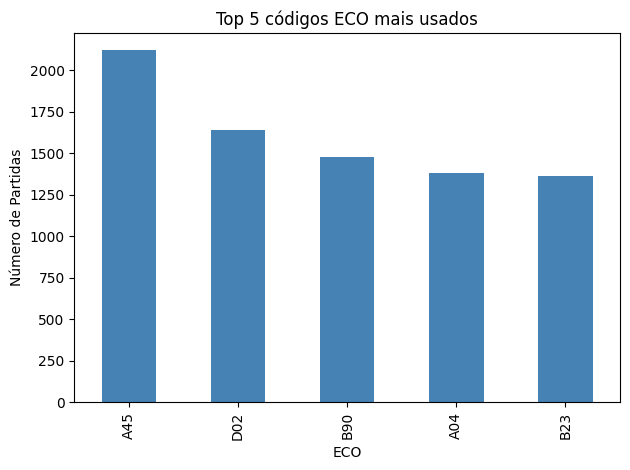

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, count, desc

# 1. Top 5 códigos ECO mais comuns
df_sample.groupBy("ECO").count().orderBy(desc("count")).limit(5).toPandas().plot(
    kind="bar", x="ECO", y="count", legend=False, color="steelblue", title="Top 5 códigos ECO mais usados"
)
plt.ylabel("Número de Partidas")
plt.tight_layout()
plt.show()

O gráfico seguinte analisa as aberturas. O destaque da abertura Sicilian — muito acima das restantes — mostra que esta é amplamente utilizada, o que é coerente com a histsória do xadrez que revela que a abertura Sicilian é das mais agressivas e populares em jogos de alto nível. As aberturas French, King’s Indian e Queen’s Pawn indicam também uma grande variedade de estilos.

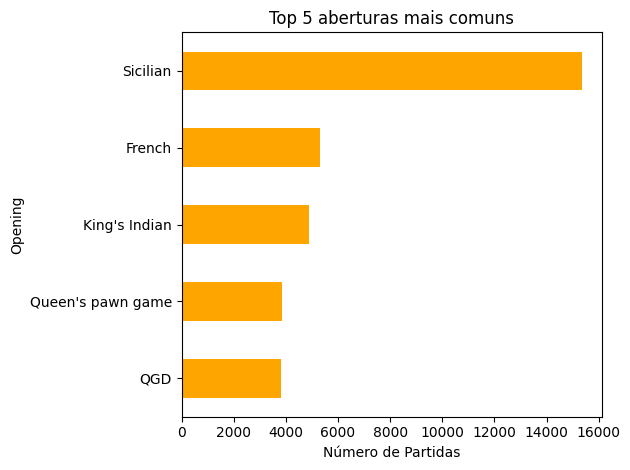

In [81]:
# 2. Top 5 aberturas mais comuns
df_sample.groupBy("Opening").count().orderBy(desc("count")).limit(5).toPandas().plot(
    kind="barh", x="Opening", y="count", legend=False, color="orange", title="Top 5 aberturas mais comuns"
)
plt.xlabel("Número de Partidas")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

A partir do gráfico das variáveis "White/BlackTitle", que compara os títulos dos jogadores que jogaram com as peças brancas e pretas, observa-se que a maioria dos jogadores não possui título oficial ("sem título"), seguido dos grandes mestres (GM), mestres internacionais (IM) e mestres FIDE (FM). A distribuição entre brancas e pretas é bastante equilibrada, o que é desejável para análises imparciais. 

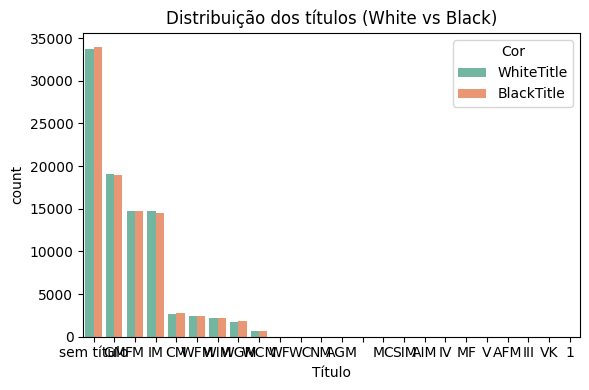

In [82]:
# 3. Distribuição de títulos dos jogadores
df_titulos = df_sample.select("WhiteTitle", "BlackTitle").toPandas()
titulos_melt = df_titulos.melt(var_name="Cor", value_name="Título")
plt.figure(figsize=(6, 4))
sns.countplot(data=titulos_melt, x="Título", hue="Cor", palette="Set2", order=titulos_melt["Título"].value_counts().index)
plt.title("Distribuição dos títulos (White vs Black)")
plt.tight_layout()
plt.show()

A partir do gráfico abaixo, conclui-se que 

•  A maioria dos valores de "EloAvg" está concentrada entre 1800 e 2600;

•  Há valores até ~2800, o que é realista (top mundial);

•  Há poucos valores abaixo de 1500, ou seja, poucos jogos de amadores principiantes;

•  Há variabilidade suficiente para o algoritmo de clustering detetar diferenças;

•  A variável não é redundante.

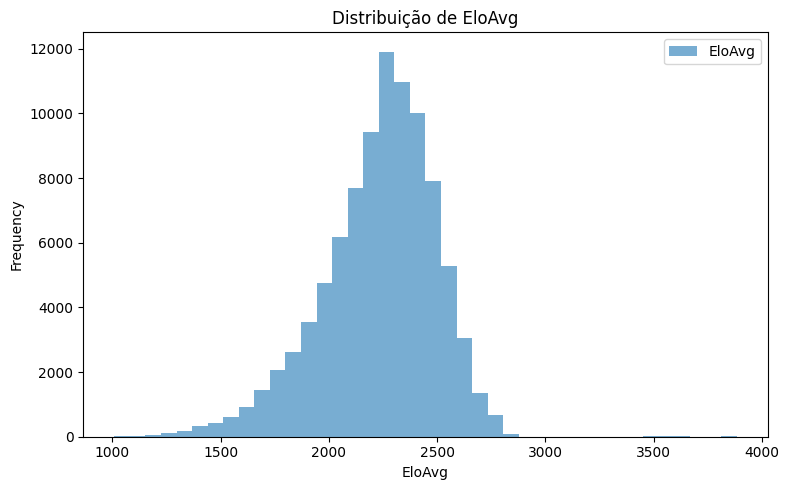

In [89]:
# 4. Histogramas de EloAvg
elos = df_sample.select("EloAvg").toPandas()
elos.plot(kind="hist", bins=40, alpha=0.6, figsize=(8, 5), title="Distribuição de EloAvg")
plt.xlabel("EloAvg")
plt.tight_layout()
plt.show()

Este último gráfico representa a distribuição do número de plies. A maioria dos jogos tem entre 80 e 140 jogadas, o que indica partidas completas, com meio-jogo e final jogados. Há também picos notáveis acima dos 160, o que pode indicar jogos longos, enquanto valores baixos (menos de 40) provavelmente representam desistências rápidas ou vitórias forçadas por erros iniciais.

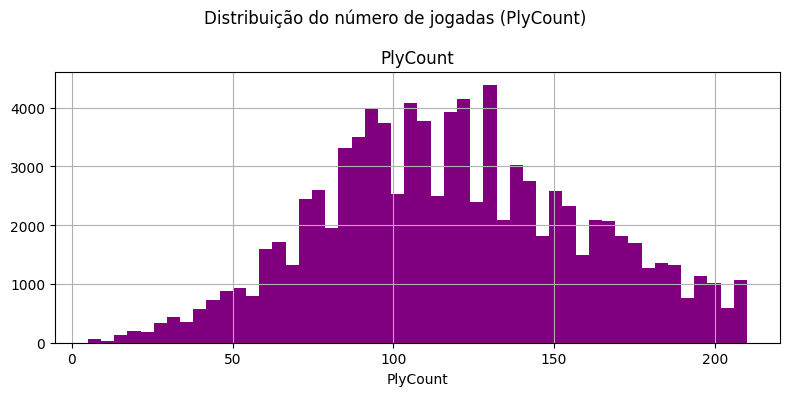

In [84]:
# 5. Distribuição de PlyCount
df_sample.select("PlyCount").toPandas().hist(bins=50, figsize=(8, 4), color="purple")
plt.suptitle("Distribuição do número de jogadas (PlyCount)")
plt.xlabel("PlyCount")
plt.tight_layout()
plt.show()

O gráfico de barras da variável "ResultNum" revela que:

- Vitórias brancas são ligeiramente mais frequentes - o que confirma o padrão conhecido no xadrez de brancas terem vantagem (por jogarem em primeiro lugar);

- Empates são menos comuns, ocorrem com menos frequência.

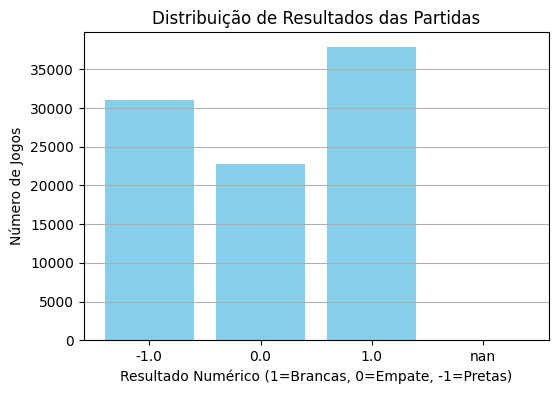

In [92]:
import matplotlib.pyplot as plt

# Agrupar e converter para Pandas
df_result = df_sample.groupBy("ResultNum").count().toPandas().sort_values("ResultNum")

# Plotar gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(df_result["ResultNum"].astype(str), df_result["count"], color='skyblue')
plt.title("Distribuição de Resultados das Partidas")
plt.xlabel("Resultado Numérico (1=Brancas, 0=Empate, -1=Pretas)")
plt.ylabel("Número de Jogos")
plt.grid(axis='y')
plt.show()


### Algoritmo K-Means

Para implementar o algoritmo K-Means, construiu-se um novo conjunto de dados - df_cluster_ready_completo - em que cada linha representa uma semana ("twic_number").

Este novo data frame contém as variáveis mais relevantes para o modelo de clustering, desde métricas numéricas agregadas dos jogos da semana (como média do Elo, nº de jogadas, resultado) e variáveis com as categorias mais representativas da semana (ex: abertura mais comum, título mais frequente) e ainda os indicadores semanais do metadata.csv (ex: nº de jogadores únicos, % online). 

In [ ]:
from pyspark.sql.functions import count, avg, sum, when, expr, first
from pyspark.sql.window import Window

# Calcular a moda (valor mais comum) por semana para variáveis categóricas
def coluna_moda(df, coluna, chave="twic_number"):
    w = Window.partitionBy(chave)
    return df.withColumn(coluna + "_freq", count(coluna).over(w)) \
             .groupBy(chave, coluna) \
             .agg(count("*").alias("freq")) \
             .orderBy("twic_number", expr("freq DESC")) \
             .dropDuplicates(["twic_number"]) \
             .select(chave, col(coluna).alias(coluna + "_mais_comum"))

# Agregações numéricas 
df_semanais = df_sample.groupBy("twic_number").agg(
    count("*").alias("n_jogos"),
    avg("WhiteElo").alias("WhiteElo"),
    avg("BlackElo").alias("BlackElo"),
    avg("PlyCount").alias("PlyCount"),
    avg("EloAvg").alias("EloAvg"),
    avg("ResultNum").alias("ResultNum"),
    (sum(when(col("ResultNum") == 1, 1).otherwise(0)) / count("*")).alias("pct_vit_brancas"),
    (sum(when(col("ResultNum") == 0, 1).otherwise(0)) / count("*")).alias("pct_empates"),
    (sum(when(col("ResultNum") == -1, 1).otherwise(0)) / count("*")).alias("pct_vit_pretas")
)

# Calcular moda de variáveis categóricas por semana
cat_moda_cols = ["ECO", "Opening", "WhiteTitle", "BlackTitle"]
modas_por_coluna = [coluna_moda(df_sample, c) for c in cat_moda_cols]

# Juntar tudo
from functools import reduce

# Juntar as modas
df_modas = reduce(lambda d1, d2: d1.join(d2, on="twic_number", how="inner"), modas_por_coluna)

# Juntar com dados agregados e metadata
df_cluster_ready_completo = df_semanais \
    .join(df_modas, on="twic_number", how="inner") \
    .join(df_meta, on="twic_number", how="inner")


In [101]:
df_semanais.show()

+-----------+-------+------------------+------------------+------------------+------------------+--------------------+-------------------+-------------------+-------------------+
|twic_number|n_jogos|          WhiteElo|          BlackElo|          PlyCount|            EloAvg|           ResultNum|    pct_vit_brancas|        pct_empates|     pct_vit_pretas|
+-----------+-------+------------------+------------------+------------------+------------------+--------------------+-------------------+-------------------+-------------------+
|        964|     91| 2318.736263736264| 2331.912087912088| 122.4065934065934|2325.3259163444413| 0.02197802197802198| 0.3516483516483517|0.31868131868131866|0.32967032967032966|
|       1258|    178|2257.0393258426966|2239.3651685393256|120.45505617977528|2248.2031370075515| 0.10112359550561797|0.38202247191011235|0.33707865168539325| 0.2808988764044944|
|       1277|     94|2151.7659574468084| 2167.372340425532| 114.2872340425532| 2159.576496040471| 0.11702

Confirmou-se que todas as semanas foram agregadas corretamente, o .count() do df_semanais deu 536, valor igual ao tamanho do ficheiro “metadata”.

In [102]:
df_semanais.count()

536

In [104]:
df_cluster_ready_completo.count()

536

In [103]:
df_cluster_ready_completo.show()

+-----------+-------+------------------+------------------+------------------+------------------+--------------------+-------------------+-------------------+-------------------+--------------+--------------------+---------------------+---------------------+-------+-------------------+-------------------+------------------+--------------+
|twic_number|n_jogos|          WhiteElo|          BlackElo|          PlyCount|            EloAvg|           ResultNum|    pct_vit_brancas|        pct_empates|     pct_vit_pretas|ECO_mais_comum|  Opening_mais_comum|WhiteTitle_mais_comum|BlackTitle_mais_comum|n_games|         start_date|           end_date|        pct_online|unique_players|
+-----------+-------+------------------+------------------+------------------+------------------+--------------------+-------------------+-------------------+-------------------+--------------+--------------------+---------------------+---------------------+-------+-------------------+-------------------+------------

Após a construção do dataset df_cluster_ready_completo, que agrega informações semanais a partir dos dados de jogos (df_sample) e do ficheiro de metadados (metadata.csv), procedeu-se à construção do modelo de clustering utilizando o algoritmo K-Means.

Porém, foi necessário repetir a primeira parte do código para garantir compatibilidade com o df_cluster_ready_completo: como as colunas disponíveis e o esquema do df_cluster_ready_completo são diferentes do df_sample, foi essencial redefinir as listas categorical_cols e non_categorical_cols com base na nova estrutura. Só assim foi possível criar corretamente o pipeline de pré-processamento (StringIndexer, OneHotEncoder e VectorAssembler) que alimenta o modelo K-Means.

O algoritmo K-Means foi treinado com k=4, ou seja, o número de grupos (clusters) foi definido como 4. A variável features foi usada como input para identificar similaridades entre semanas.

Após o treino, o modelo atribuiu a cada semana um valor de prediction que indica a qual grupo pertence. 

In [116]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Colunas categóricas e numéricas no df_cluster_ready_completo
categorical_cols = ['ECO_mais_comum', 'Opening_mais_comum', 'WhiteTitle_mais_comum', 'BlackTitle_mais_comum']
non_categorical_cols = ['WhiteElo', 'BlackElo', 'PlyCount', 'EloAvg', 'ResultNum',
                        'pct_vit_brancas', 'pct_empates', 'pct_vit_pretas',
                        'pct_online', 'unique_players', 'n_jogos']

# Preparar indexação e codificação
index_output_cols = [c + " Index" for c in categorical_cols]
ohe_output_cols = [c + " OHE" for c in categorical_cols]

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")
ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)
vec_assembler = VectorAssembler(inputCols=ohe_output_cols + non_categorical_cols, outputCol="features")


In [117]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans

pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler])
df_preparado = pipeline.fit(df_cluster_ready_completo).transform(df_cluster_ready_completo)

kmeans = KMeans(featuresCol="features", k=4, seed=42)
modelo_kmeans = kmeans.fit(df_preparado)
df_resultado = modelo_kmeans.transform(df_preparado)

df_resultado.select("twic_number", "prediction").show()


+-----------+----------+
|twic_number|prediction|
+-----------+----------+
|        920|         1|
|        921|         1|
|        922|         0|
|        923|         2|
|        924|         3|
|        925|         3|
|        926|         0|
|        927|         0|
|        928|         3|
|        929|         3|
|        930|         3|
|        931|         2|
|        932|         1|
|        933|         1|
|        934|         0|
|        935|         1|
|        936|         0|
|        937|         0|
|        938|         1|
|        939|         3|
+-----------+----------+
only showing top 20 rows



O código abaixo revela a média de cada variável em cada cluster. Assim, foi possível criar perfis para cada cluster.

A partir da média das variáveis por cluster, verificou-se que algumas métricas apresentam diferenças mais marcantes entre os grupos, tornando-se assim as melhores para a segmentação obtida pelo modelo de K-Means.

In [118]:
from pyspark.sql.functions import count, avg, round as rnd, first

# Variáveis numéricas para média
variaveis_numericas = [
    "WhiteElo", "BlackElo", "PlyCount", "EloAvg", "ResultNum",
    "pct_vit_brancas", "pct_empates", "pct_vit_pretas",
    "pct_online", "unique_players", "n_jogos"
]

# Variáveis categóricas (moda por cluster)
variaveis_categoricas = [
    "ECO_mais_comum", "Opening_mais_comum", "WhiteTitle_mais_comum", "BlackTitle_mais_comum"
]

# Calcular médias e primeiras ocorrências das categorias por cluster
df_perfis = df_resultado.groupBy("prediction").agg(
    *[rnd(avg(v), 2).alias(v) for v in variaveis_numericas],
    *[first(c).alias(c) for c in variaveis_categoricas]
).orderBy("prediction")

df_perfis.show(truncate=False)


+----------+--------+--------+--------+-------+---------+---------------+-----------+--------------+----------+--------------+-------+--------------+-----------------------+---------------------+---------------------+
|prediction|WhiteElo|BlackElo|PlyCount|EloAvg |ResultNum|pct_vit_brancas|pct_empates|pct_vit_pretas|pct_online|unique_players|n_jogos|ECO_mais_comum|Opening_mais_comum     |WhiteTitle_mais_comum|BlackTitle_mais_comum|
+----------+--------+--------+--------+-------+---------+---------------+-----------+--------------+----------+--------------+-------+--------------+-----------------------+---------------------+---------------------+
|0         |2248.17 |2245.7  |118.34  |2246.95|0.07     |0.4            |0.28       |0.32          |0.15      |1456.77       |150.71 |B71           |Queen's gambit accepted|CM                   |WIM                  |
|1         |2289.17 |2285.97 |117.76  |2287.58|0.08     |0.4            |0.29       |0.31          |0.16      |983.73        |95

In [120]:
df_resultado.groupBy("prediction").count().orderBy("prediction").show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  200|
|         1|  135|
|         2|   45|
|         3|  156|
+----------+-----+



In [122]:
# Gerar análise textual por cluster
df_perfis_pd = df_perfis.toPandas()

for i, row in df_perfis_pd.iterrows():
    print(f"\n Cluster {int(row['prediction'])} – Perfil Típico:")
    print(f"  • Elo médio: {row['EloAvg']:.0f} (White: {row['WhiteElo']:.0f}, Black: {row['BlackElo']:.0f})")
    print(f"  • Jogadas médias (PlyCount): {row['PlyCount']:.0f}")
    print(f"  • Resultado médio: {row['ResultNum']:.2f} (1=brancas, 0=empate, -1=pretas)")
    print(f"  • % Vitórias Brancas: {row['pct_vit_brancas']:.1%}, Empates: {row['pct_empates']:.1%}, Pretas: {row['pct_vit_pretas']:.1%}")
    print(f"  • % Online: {row['pct_online']:.1%}")
    print(f"  • Jogadores únicos: {row['unique_players']:.0f}")
    print(f"  • Nº de jogos: {row['n_jogos']:.0f}")
    print(f"  • ECO mais comum: {row['ECO_mais_comum']}")
    print(f"  • Abertura mais comum: {row['Opening_mais_comum']}")
    print(f"  • Título mais comum (brancas): {row['WhiteTitle_mais_comum']}")
    print(f"  • Título mais comum (pretas): {row['BlackTitle_mais_comum']}")



 Cluster 0 – Perfil Típico:
  • Elo médio: 2247 (White: 2248, Black: 2246)
  • Jogadas médias (PlyCount): 118
  • Resultado médio: 0.07 (1=brancas, 0=empate, -1=pretas)
  • % Vitórias Brancas: 40.0%, Empates: 28.0%, Pretas: 32.0%
  • % Online: 15.0%
  • Jogadores únicos: 1457
  • Nº de jogos: 151
  • ECO mais comum: B71
  • Abertura mais comum: Queen's gambit accepted
  • Título mais comum (brancas): CM
  • Título mais comum (pretas): WIM

 Cluster 1 – Perfil Típico:
  • Elo médio: 2288 (White: 2289, Black: 2286)
  • Jogadas médias (PlyCount): 118
  • Resultado médio: 0.08 (1=brancas, 0=empate, -1=pretas)
  • % Vitórias Brancas: 40.0%, Empates: 29.0%, Pretas: 31.0%
  • % Online: 16.0%
  • Jogadores únicos: 984
  • Nº de jogos: 95
  • ECO mais comum: C00
  • Abertura mais comum: Queen's pawn
  • Título mais comum (brancas): WIM
  • Título mais comum (pretas): CM

 Cluster 2 – Perfil Típico:
  • Elo médio: 2155 (White: 2157, Black: 2153)
  • Jogadas médias (PlyCount): 118
  • Resultado 

Gerou-se uma visualização gráfica para as variáveis numéricas de forma a simplificar a interpretação de perfis. 

/tmp/ipykernel_635/396003639.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="prediction", y=var, data=df_perfis_pd, palette="Set2")


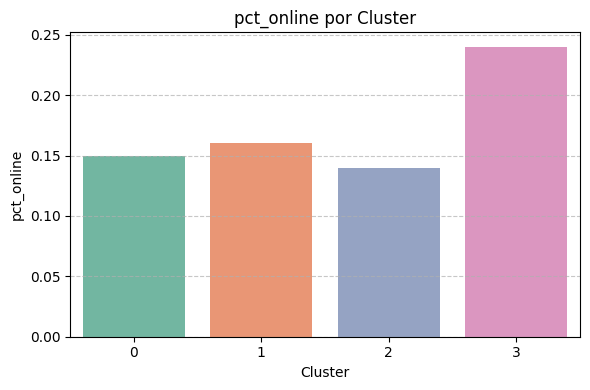

/tmp/ipykernel_635/396003639.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="prediction", y=var, data=df_perfis_pd, palette="Set2")


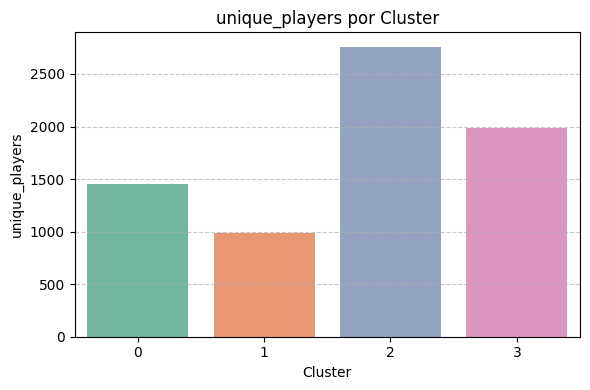

/tmp/ipykernel_635/396003639.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="prediction", y=var, data=df_perfis_pd, palette="Set2")


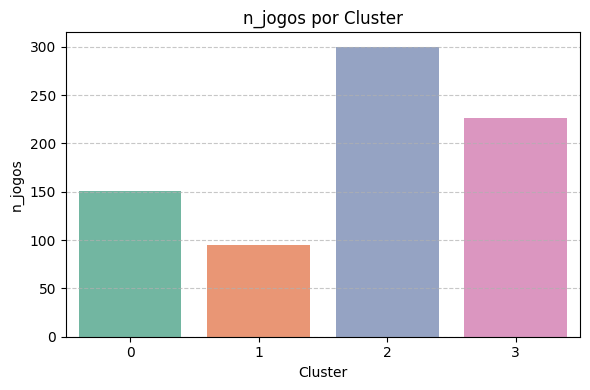

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variáveis a visualizar (sem categóricas)
variaveis_visuais = [
    "pct_online", "unique_players", "n_jogos"
]

# Gráficos de barras por variável
for var in variaveis_visuais:
    plt.figure(figsize=(6, 4))
    sns.barplot(x="prediction", y=var, data=df_perfis_pd, palette="Set2")
    plt.title(f"{var} por Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
